In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D
from tensorflow.keras.models import Model

plt.rcParams['font.size'] = 16

# Inception V1/GoogleNet

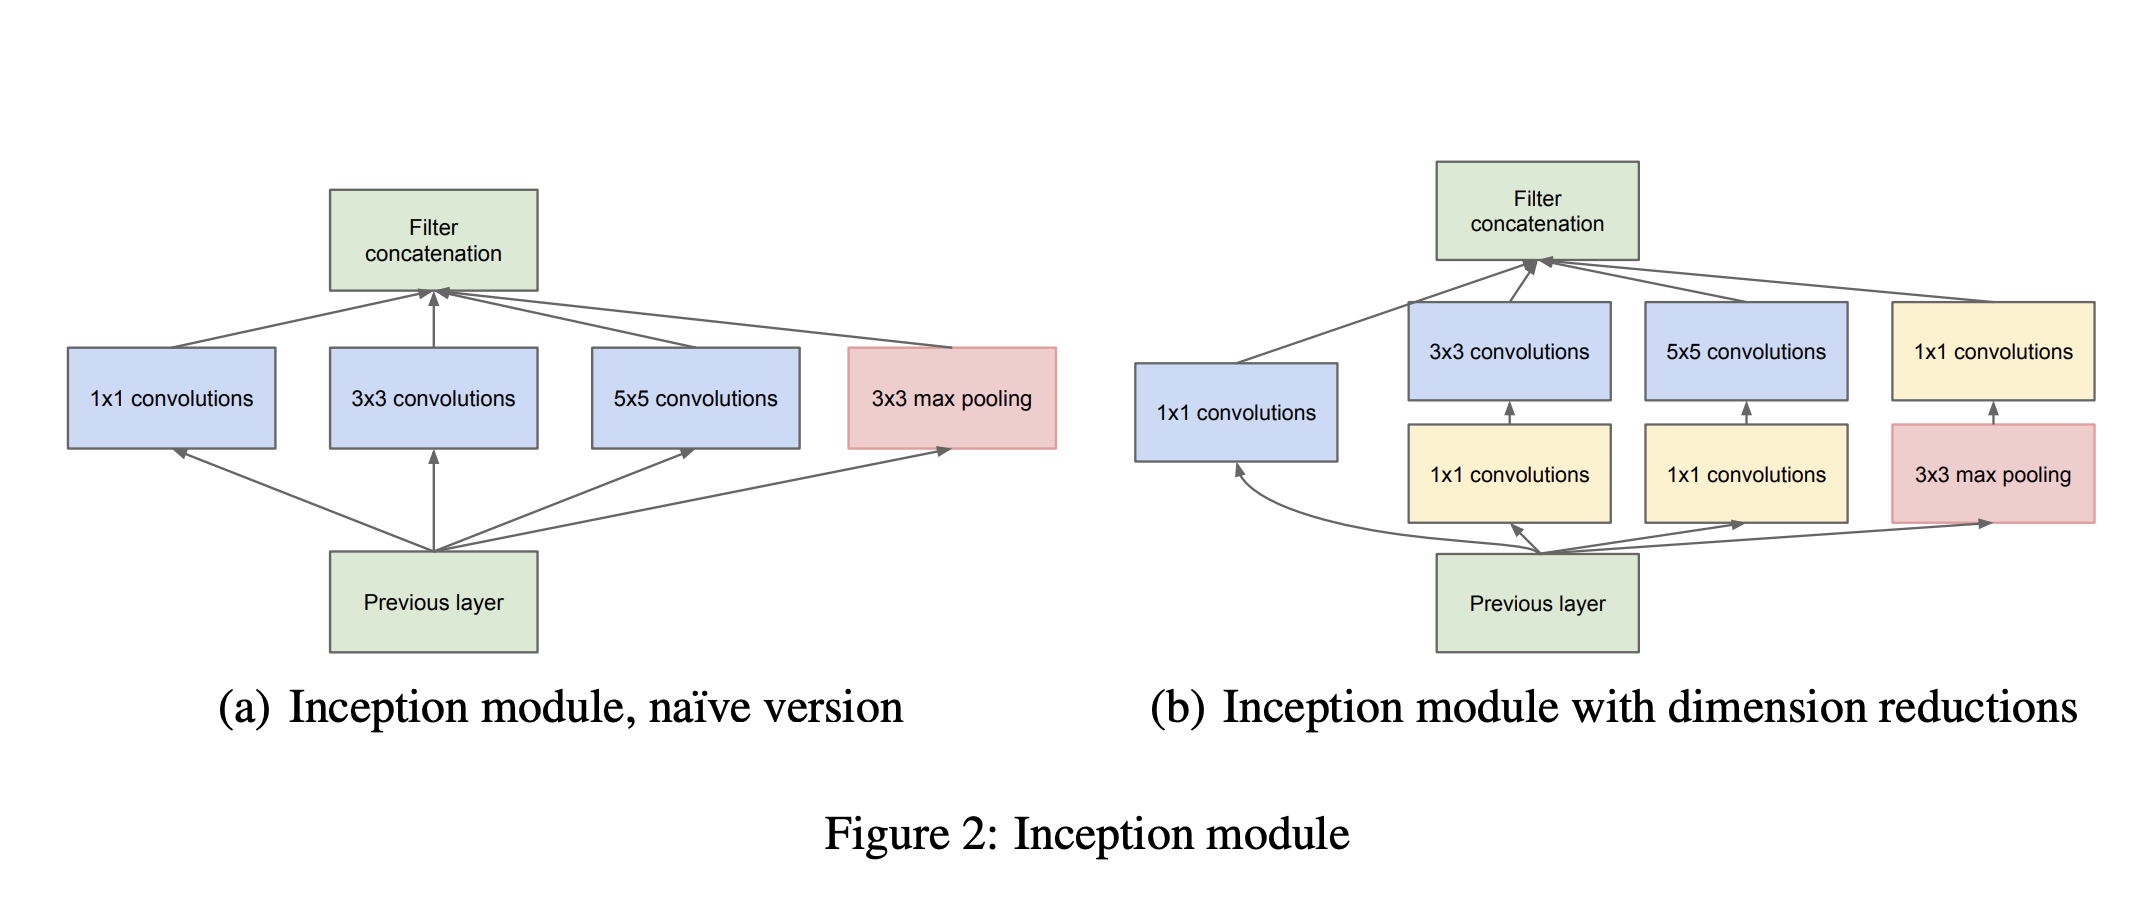

In [2]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, kernel_size=(1,1), padding='same', activation='relu')(x)
    
    preconv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, kernel_size=(3,3), padding='same', activation='relu')(preconv_3x3)
    
    preconv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, kernel_size=(5,5), padding='same', activation='relu')(preconv_5x5)
    
    pool_proj = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, kernel_size=(1,1), padding='same', activation='relu')(pool_proj)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

# Architecture

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20200429201421/Inception-layer-by-layer.PNG'>

In [3]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, (7,7), padding='same', strides=(2,2), activation='relu')(input_layer)
x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = Conv2D(64, (1,1), padding='same',activation='relu')(x)
x = Conv2D(192, (3,3), padding='same',activation='relu')(x)
x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = inception_module(x, 64, 96, 128, 16, 32, 32, 'inception_3a')
x = inception_module(x, 128, 128, 192, 32, 96, 64, 'inception_3b')
x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64, 'inception_4a')
x = inception_module(x, 160, 112, 224, 24, 64, 64, 'inception_4b')
x = inception_module(x, 128, 128, 256, 24, 64, 64, 'inception_4c')
x = inception_module(x, 112, 144, 288, 32, 64, 64, 'inception_4d')
x = inception_module(x, 256, 160, 320, 32, 128, 128, 'inception_4e')
x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = inception_module(x, 256, 160, 320, 32, 128, 128, 'inception_5a')
x = inception_module(x, 384, 192, 384, 48, 128, 128, 'inception_5b')
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output_layer = Dense(10, activation='softmax', name='output')(x)

googlenet = Model(inputs=input_layer, outputs=output_layer)

In [4]:
googlenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

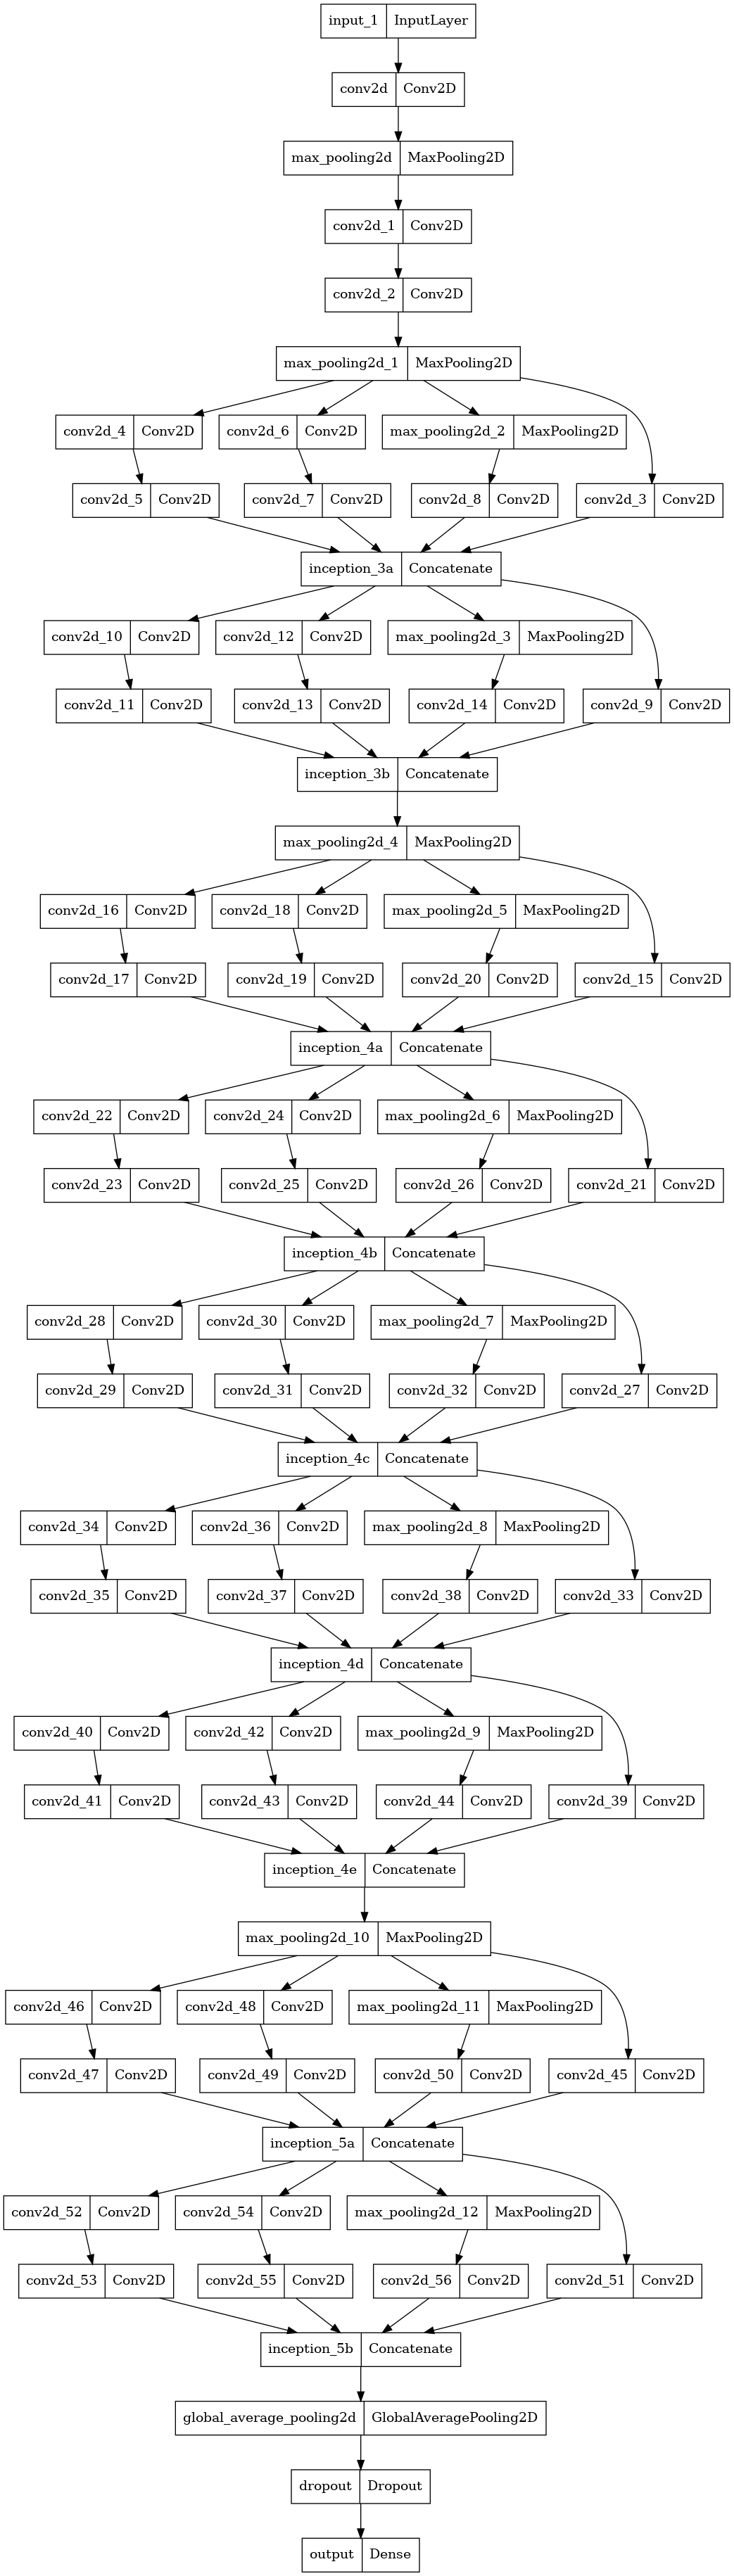

In [5]:
tf.keras.utils.plot_model(googlenet,to_file='googlenet.png')

# Inception v1 with Auxillary Classifiers

<img src='https://www.lri.fr/~gcharpia/deeppractice/2020/images/Inception.png'>

In [6]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, (7,7), padding='same', strides=(2,2), activation='relu')(input_layer)
x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = Conv2D(64, (1,1), padding='same',activation='relu')(x)
x = Conv2D(192, (3,3), padding='same',activation='relu')(x)
x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)

x = inception_module(x, 64, 96, 128, 16, 32, 32, 'inception_3a')
x = inception_module(x, 128, 128, 192, 32, 96, 64, 'inception_3b')
x = inception_module(x, 192, 96, 208, 16, 48, 64, 'inception_3c')

aux1_avg = GlobalAveragePooling2D()(x)
aux1_dropout = Dropout(0.4)(aux1_avg)
aux1_output = Dense(10, activation='softmax', name='aux1_output')(aux1_dropout)

x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = inception_module(x, 160, 112, 224, 24, 64, 64, 'inception_4a')
x = inception_module(x, 128, 128, 256, 24, 64, 64, 'inception_4b')

aux2_avg = GlobalAveragePooling2D()(x)
aux2_dropout = Dropout(0.4)(aux2_avg)
aux2_output = Dense(10, activation='softmax', name='aux2_output')(aux2_dropout)

x = MaxPooling2D((3,3), padding='same', strides=(2,2))(x)
x = inception_module(x, 256, 160, 320, 32, 128, 128, 'inception_5a')
x = inception_module(x, 256, 160, 320, 32, 128, 128, 'inception_5b')
x = inception_module(x, 384, 192, 384, 48, 128, 128, 'inception_5c')
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output_layer = Dense(10, activation='softmax', name='output')(x)

googlenet = Model(inputs=input_layer, outputs=[aux1_output, aux2_output, output_layer])

In [7]:
googlenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_57[0][0]']              
 )                                                                                          

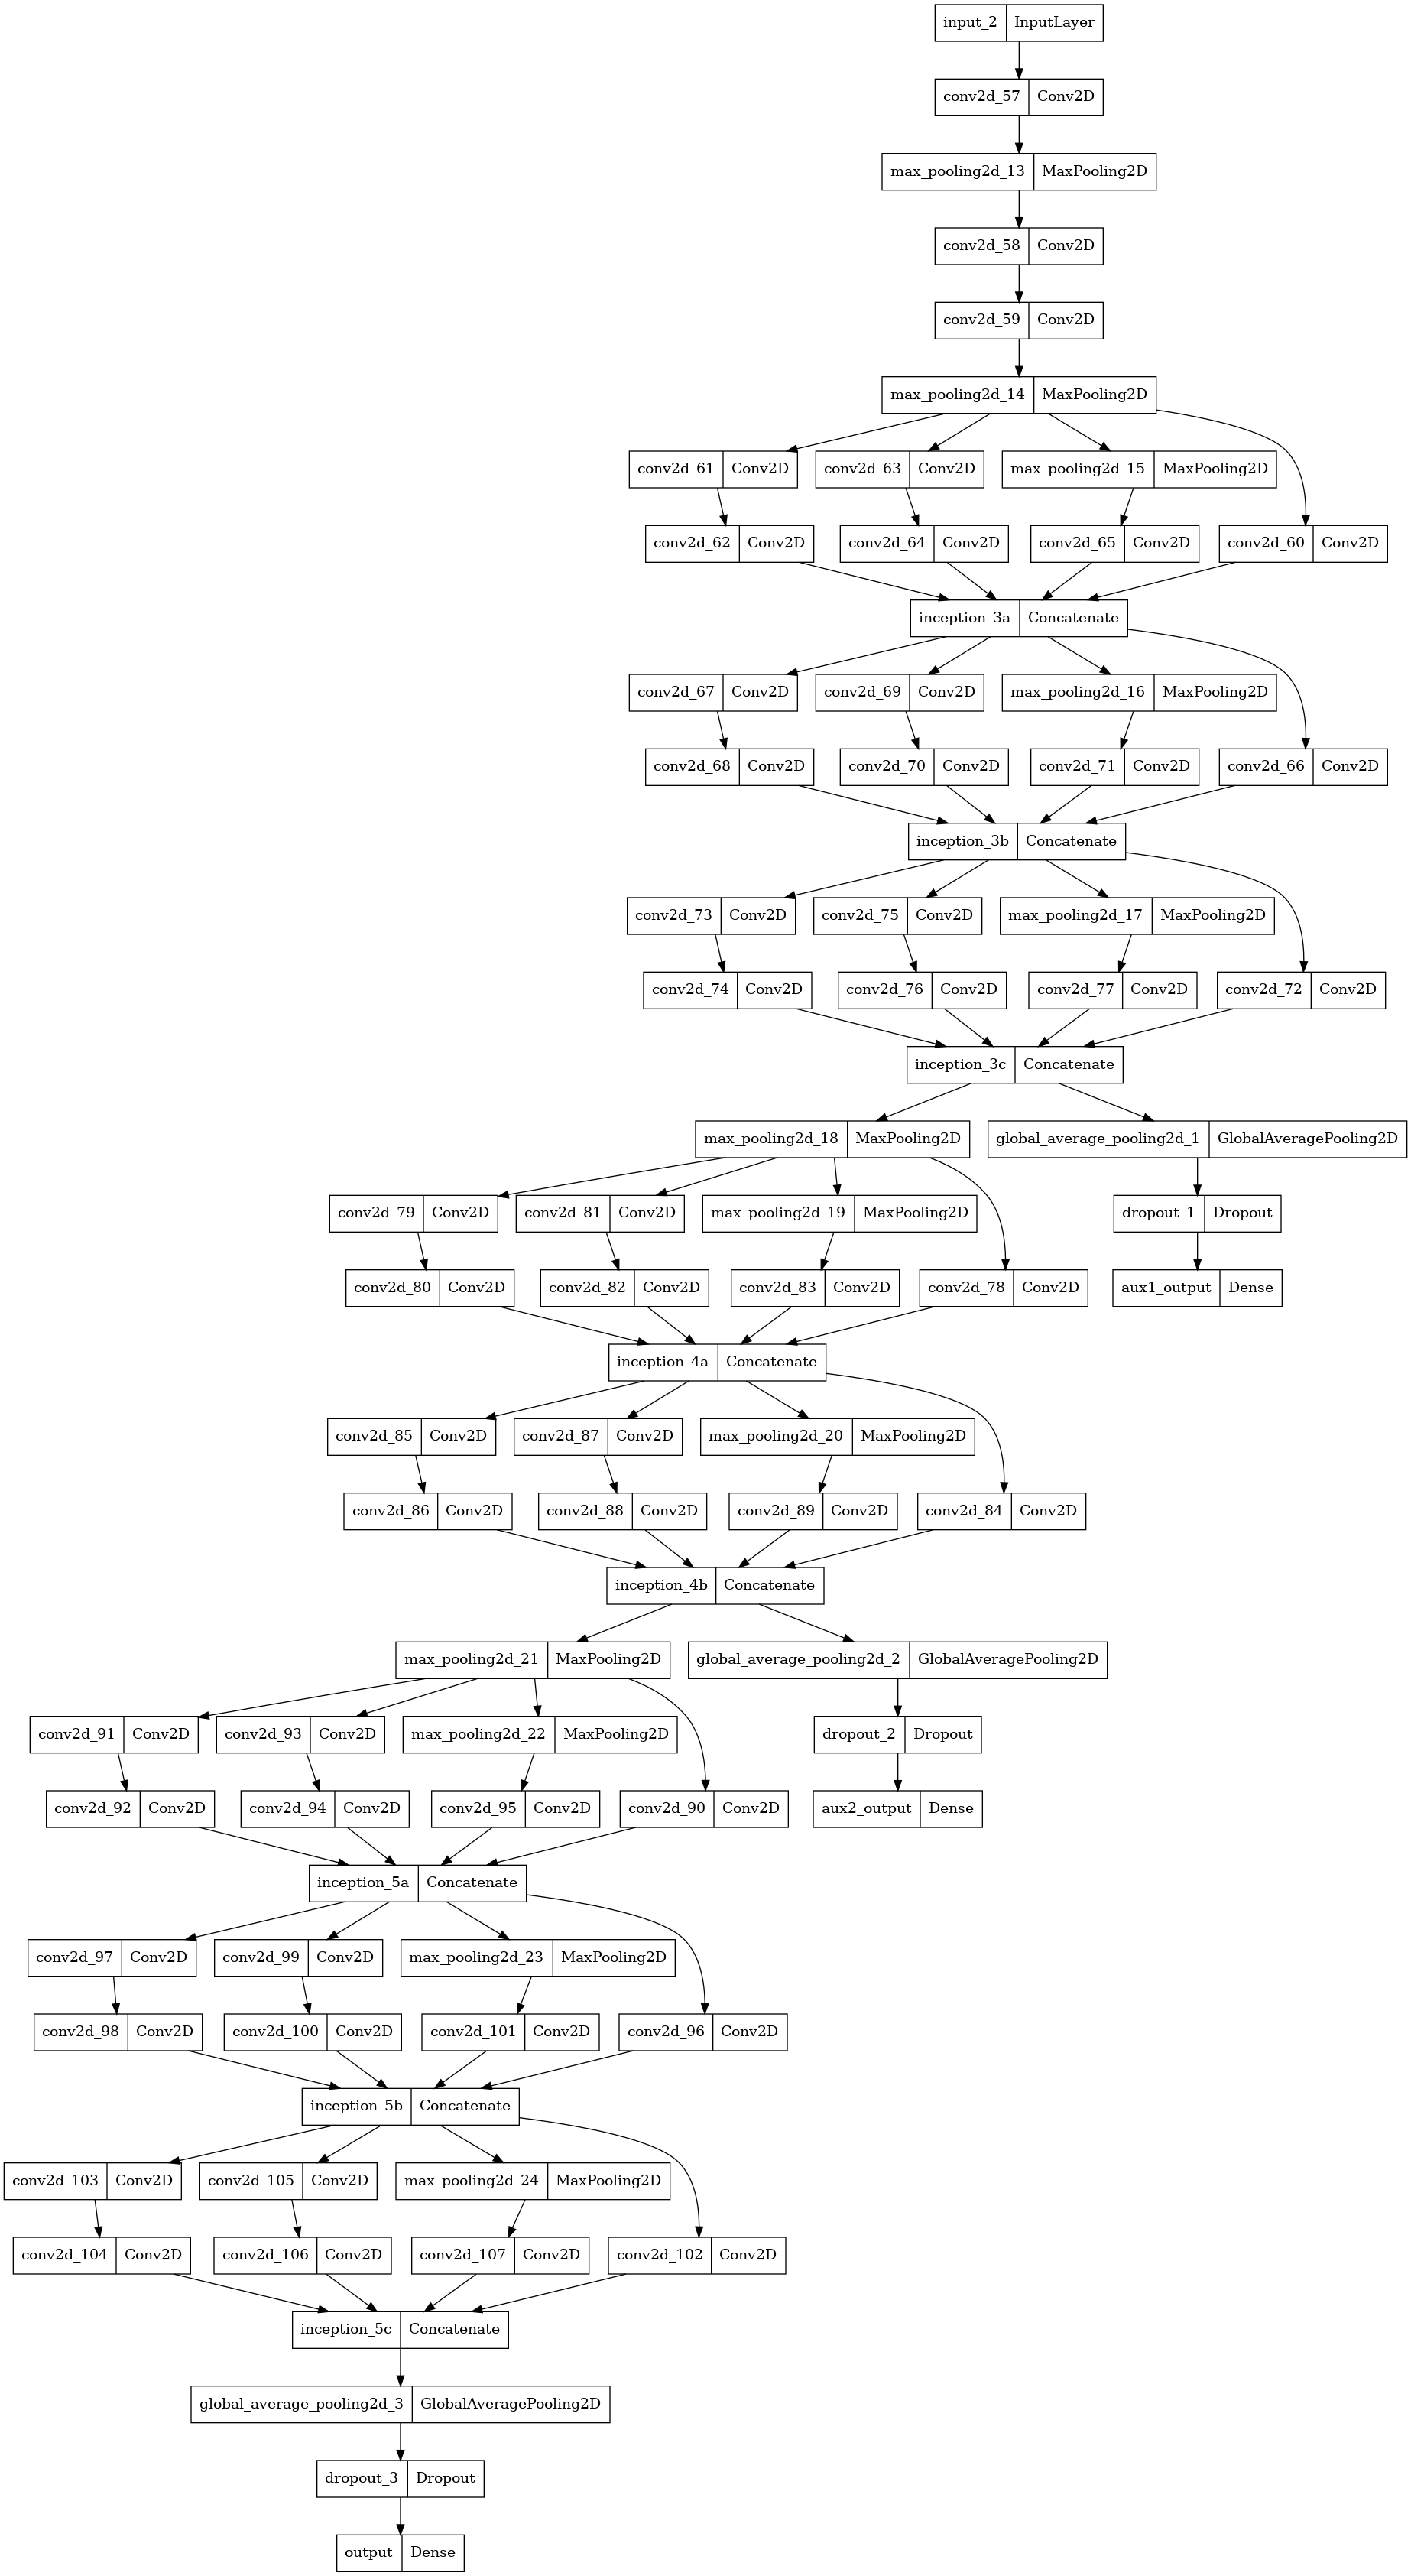

In [8]:
tf.keras.utils.plot_model(googlenet,to_file='googlenet_aux.png')

# ResNet (Layers: 18,34,50,101,152)

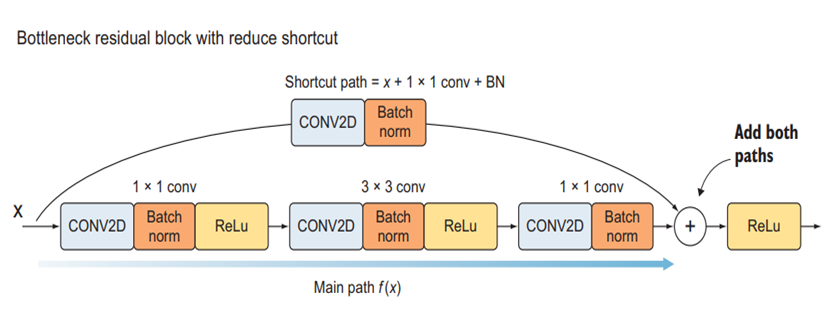

In [9]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x
    
    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

# Architecture

<img src='https://miro.medium.com/max/1400/1*I2557MCaFdNUm4q9TfvOpw.png'>

In [10]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(64, kernel_size=(7,7), strides=(2,2))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)
x = residual_block(x,3,[64,64,128],s=1)

x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])
x = residual_block(x,3,[128,128,512])

x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])
x = residual_block(x,3,[256,256,1024])

x = residual_block(x,3,[512,512,2048])
x = residual_block(x,3,[512,512,2048])
x = residual_block(x,3,[512,512,2048])

x = GlobalAveragePooling2D()(x)
output_layer = Dense(10, activation='softmax')(x)

resnet50 = Model(inputs=input_layer,outputs=output_layer)

In [11]:
resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 109, 109, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 109, 109, 64  256        ['conv2d_108[0][0]']             
 alization)                     )                                                           

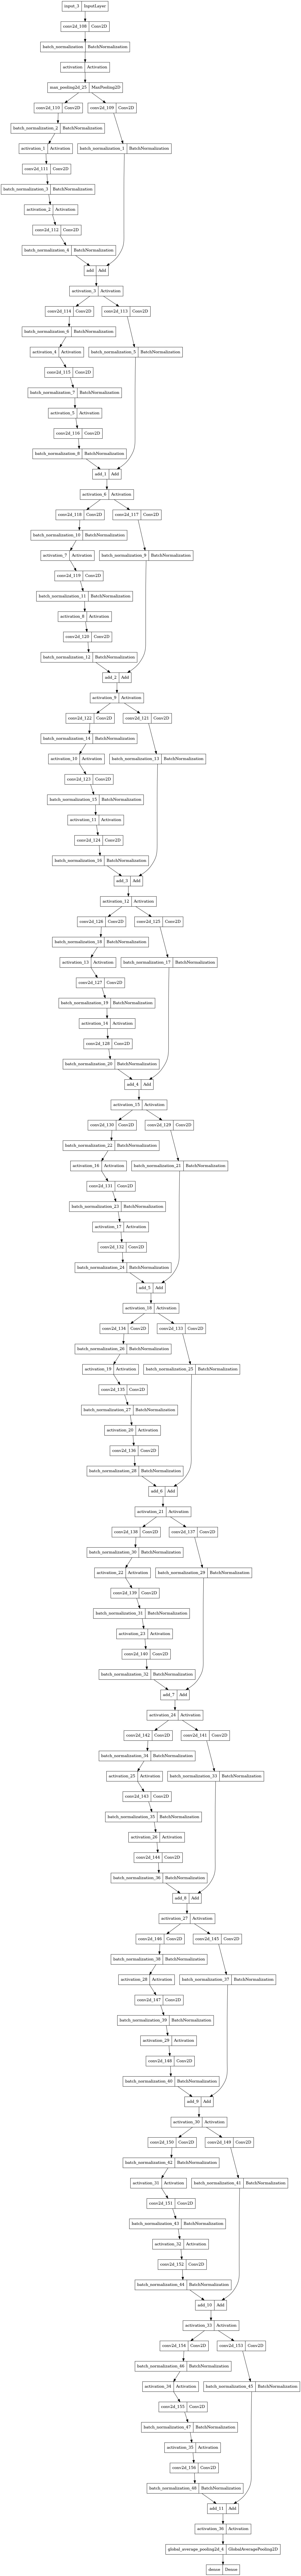

In [12]:
tf.keras.utils.plot_model(resnet50,to_file='resnet50.png')

# MobileNet

<img src='https://www.researchgate.net/publication/343943234/figure/fig1/AS:1000897064738828@1615643864512/Depthwise-separable-convolution-block.png'>

In [13]:
def mobilenet_block(x, kernel_size, filters, strides):
    x = DepthwiseConv2D(kernel_size=(kernel_size,kernel_size), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size=(1,1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Architecture

<img src='https://www.researchgate.net/publication/331675538/figure/fig2/AS:735605247967235@1552393366382/layers-of-MobileNet-architecture-4.ppm'>

In [14]:
input_layer = Input(shape=(224,224,3))
x = Conv2D(32, kernel_size=(3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = mobilenet_block(x, 3, 64, 1)
x = mobilenet_block(x, 3, 128, 2)
x = mobilenet_block(x, 3, 128, 1)
x = mobilenet_block(x, 3, 256, 2)
x = mobilenet_block(x, 3, 256, 1)
x = mobilenet_block(x, 3, 512, 2)

for _ in range(5):
    x = mobilenet_block(x, 3, 512, 1)
    
x = mobilenet_block(x, 3, 1024, 2)
x = mobilenet_block(x, 3, 1024, 2)
x = GlobalAveragePooling2D()(x)
output_layer = Dense(10, activation='softmax')(x)

mobilenet = Model(inputs=input_layer, outputs=output_layer)

In [15]:
mobilenet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_157 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_49 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 activation_37 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_50 (Bat  (None, 112, 112, 32)     128 

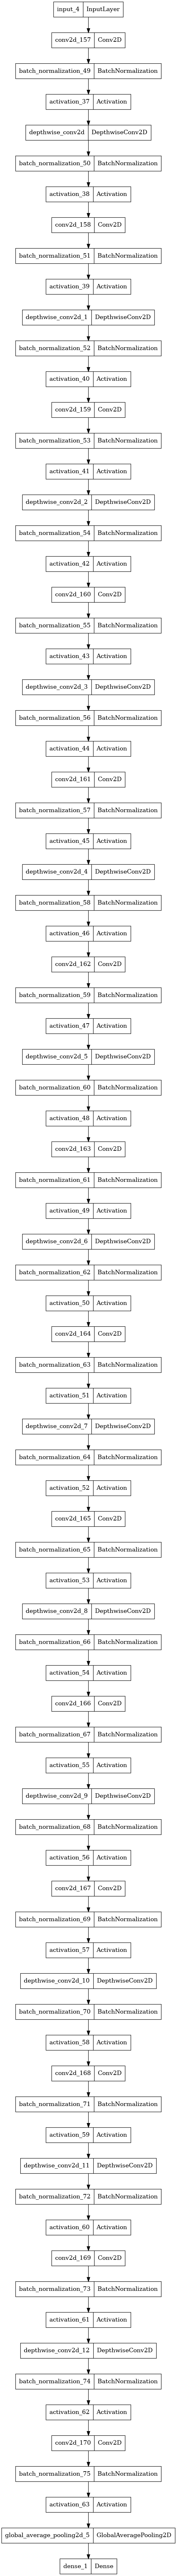

In [16]:
tf.keras.utils.plot_model(mobilenet,to_file='mobilenet.png')